## 02-TimeSeries-Forecasting-PyTorch-Lightning.ipynb
The notebook explores time series forecasting techniques using Pytorch Lightining.

Kernel = timeseriespytorchlight

#### Imports

In [19]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [20]:
# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss

import torch

#### Variables

In [21]:
#Note: This file is created in previous notebook to avoid repetition of the dataset transformation steps.
out_CSV_directory = '../transformed'
out_CSV_filename = 'GroundLevelOzone_merged_CAPMCABC1SAT.csv'
out_CSV_path = os.path.join(out_CSV_directory,out_CSV_filename)

#### Pandas configurations

In [22]:
#Show all dataframe columns
pd.set_option('display.max_columns', None)

#### Background colour 
for warning messages

In [23]:
import sys
import logging
from importlib import reload

reload(logging)
logging.basicConfig(stream=sys.stdout, format='', level=logging.INFO, datefmt=None)

log = logging.getLogger(__name__)
log.info("Normal stdout test.")

Normal stdout test.


#### Review the dataset

In [24]:
df_GroundLevelOzone_merged_CAPMCABC1SAT_subset = pd.read_csv(filepath_or_buffer = out_CSV_path, 
                                      sep=",", 
                                      skiprows = 0, 
                                      skipfooter = 0, 
                                      quotechar='"',                                       
                                      encoding_errors = 'ignore',                                      
                                      header = 0
                                     )

print(f'df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.shape: {df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.shape}')

df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.shape: (17497, 5)


In [25]:
df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.head(2)

,idx,Date,Hour,MonthNo,O3_ppbv
0,0,2014-01-01,0,1,4.1
1,1,2014-01-01,1,1,2.9


In [26]:
df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.tail(2)

,idx,Date,Hour,MonthNo,O3_ppbv
17495,17495,2015-12-30,23,12,25.4
17496,17496,2015-12-31,0,12,21.3


In [27]:
df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.dtypes

idx          int64
Date        object
Hour         int64
MonthNo      int64
O3_ppbv    float64
dtype: object

In [28]:
#Update the data types
df_GroundLevelOzone_merged_CAPMCABC1SAT_subset['Date'] = pd.to_datetime(df_GroundLevelOzone_merged_CAPMCABC1SAT_subset['Date'])

In [29]:
df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.dtypes

idx                 int64
Date       datetime64[ns]
Hour                int64
MonthNo             int64
O3_ppbv           float64
dtype: object

#### Dataset conversion

In [30]:
#Copy the input data into a new object
data = df_GroundLevelOzone_merged_CAPMCABC1SAT_subset[:].copy(deep = True)
data['siteID'] = 'CAPMCABC1SAT'

max_prediction_length = 48  # Forecast 48 hours
max_encoder_length = data.shape[0] - max_prediction_length  # Use all history except the last 48 records from our hourly dataset
training_cutoff = data["idx"].max() - max_prediction_length

print(f'max_prediction_length: {max_prediction_length}, max_encoder_length: {max_encoder_length}, training_cutoff: {training_cutoff}')

max_prediction_length: 48, max_encoder_length: 17449, training_cutoff: 17448


In [31]:
# data_subset = data.iloc[:training_cutoff].copy(deep = True)

training = TimeSeriesDataSet(
    data[lambda x: x.idx <= training_cutoff],     
    time_idx="idx",
    target = 'O3_ppbv',
    group_ids = ['siteID'],
    min_encoder_length = max_prediction_length // 2,  # allow predictions without history
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    static_categoricals = [],
    static_reals=[],
    time_varying_known_categoricals=[],
    
    # group of categorical variables can be treated as one variable
    # variable_groups = {"special_days": special_days},
    
    time_varying_known_reals=[
        'idx',
        'MonthNo'        
    ],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals = ['O3_ppbv'],
    
    scalers = {},   
    
    add_relative_time_idx = True,  # add as feature
    add_target_scales = False,      # add as feature
    add_encoder_length = True     # add as feature       
)

In [32]:
#To check if pyarrow is installed
# pd.show_versions()

#### Model training

In [33]:
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

batch_size = 64 #64
max_epochs = 10 #100
patience = max_epochs // 2
num_workers = 6 #No of CPUs on the VM

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers = num_workers) 
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers = num_workers)

In [34]:
# save datasets
training.save("training.pkl")
validation.save("validation.pkl")

In [35]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta = 1e-4, patience = patience, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
# logger = TensorBoardLogger(log_graph=True)

In [36]:
trainer = pl.Trainer(
    max_epochs = max_epochs,
    gpus = -1,                #Select all gpus
    auto_select_gpus = False, 
    gradient_clip_val = 0.1,
    limit_train_batches = 64, #30,
    val_check_interval = 64,
    limit_val_batches = 1.0,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
    callbacks = [lr_logger, early_stop_callback],
    log_every_n_steps = 50
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [37]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.05,
    hidden_size = 16, #16,
    attention_head_size = 1,
    dropout = 0.1,
    hidden_continuous_size = 8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    log_val_interval=10,
    reduce_on_plateau_patience=3,
)

In [38]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 18.9k


Uncomment and run below cell to get the value of suggested Learning Rate

In [39]:
# %%capture --no-display

# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloader = train_dataloader,
#     val_dataloaders = val_dataloader,
#     max_lr = 1.0,
#     min_lr = 1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

# res.suggestion()

#### Fit model
With revised learning_rate

In [40]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.025, #0.05,
    hidden_size = 16, #16,
    attention_head_size = 1,
    dropout = 0.1,
    hidden_continuous_size = 8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval = 10,
    log_val_interval=1,
    reduce_on_plateau_patience=3,
)

In [41]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 18.9k


#### <i> Please ignore the warning in cell output below </i>

UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow.

This is due to an active issue in pytorch-forecasting (Ref: https://github.com/jdb78/pytorch-forecasting/issues/714) which will be fixed in future release.

In [42]:
# %%capture --no-display

# fit network (Took ~1 Hr on 1 x NVIDIA Tesla K80 GPU)
trainer.fit(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 528   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


Training: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in bat

Validating: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in bat

Validating: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in bat

Validating: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in bat

Validating: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in bat

Validating: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in bat

Validating: 0it [00:00, ?it/s]

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


#### View results

In [51]:
# %%capture --no-display

#Evaluate performance

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
print('*************************************************')
print(f'MAE: {(actuals - predictions).abs().mean()}')
print(f'best_model_path: {best_model_path}')
print('*************************************************')

/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/anaconda/envs/timeseriespytorchlight/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in bat

*************************************************
MAE: 6.454086780548096
best_model_path: /mnt/batch/tasks/shared/LS_root/mounts/clusters/computeinstance5-gpu/code/Users/makandha/Python/TimeSeries/notebooks/lightning_logs/version_41/checkpoints/epoch=5-step=383.ckpt
*************************************************


In [44]:
%%capture --no-display

# Raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

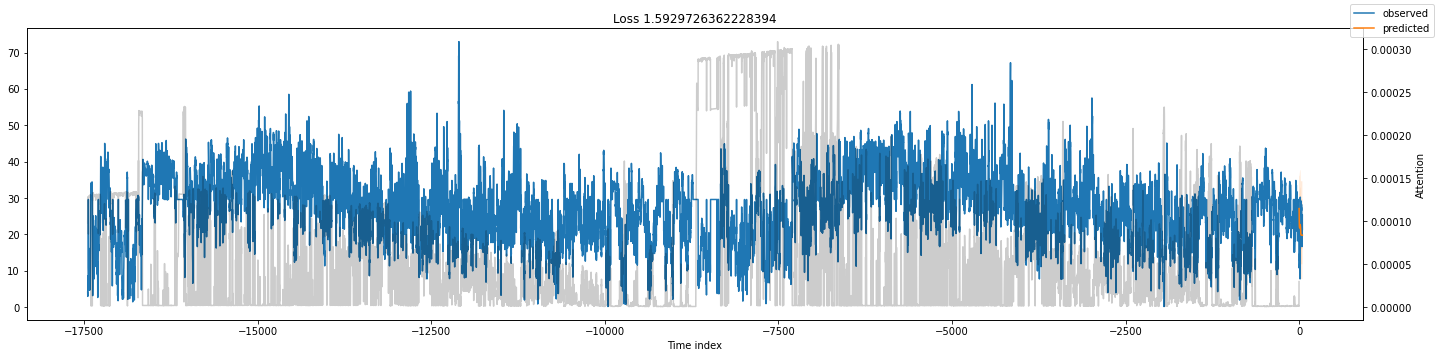

In [56]:
plt.rcParams.update({'figure.figsize': (20,5)})

for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [57]:
type(best_tft)

pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer

#### Interpret model

{'attention': <Figure size 720x360 with 1 Axes>,
 'static_variables': <Figure size 504x162 with 1 Axes>,
 'encoder_variables': <Figure size 504x216 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>}

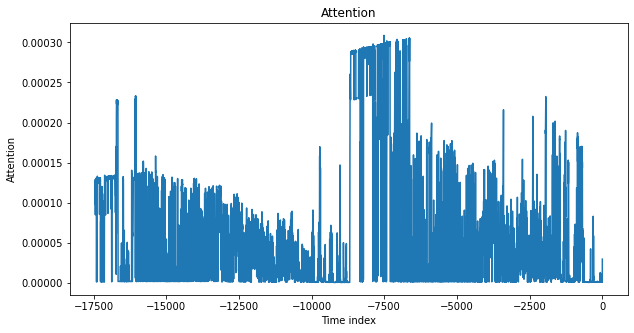

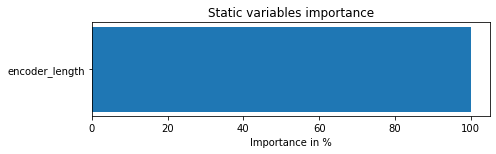

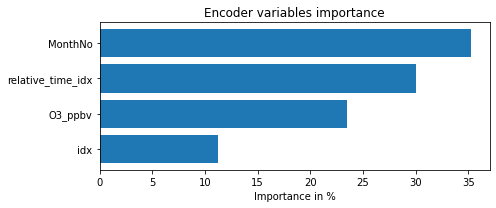

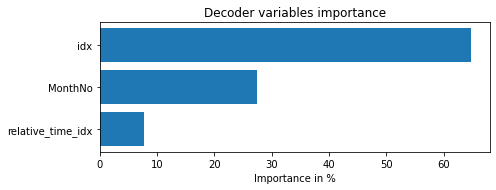

In [55]:
plt.rcParams.update({'figure.figsize': (10,5)})

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)